**Very poor rag performance, failed to extract proper information**

In [ ]:
print("OK")

# Q&A over the Code Base to Understand How it Works

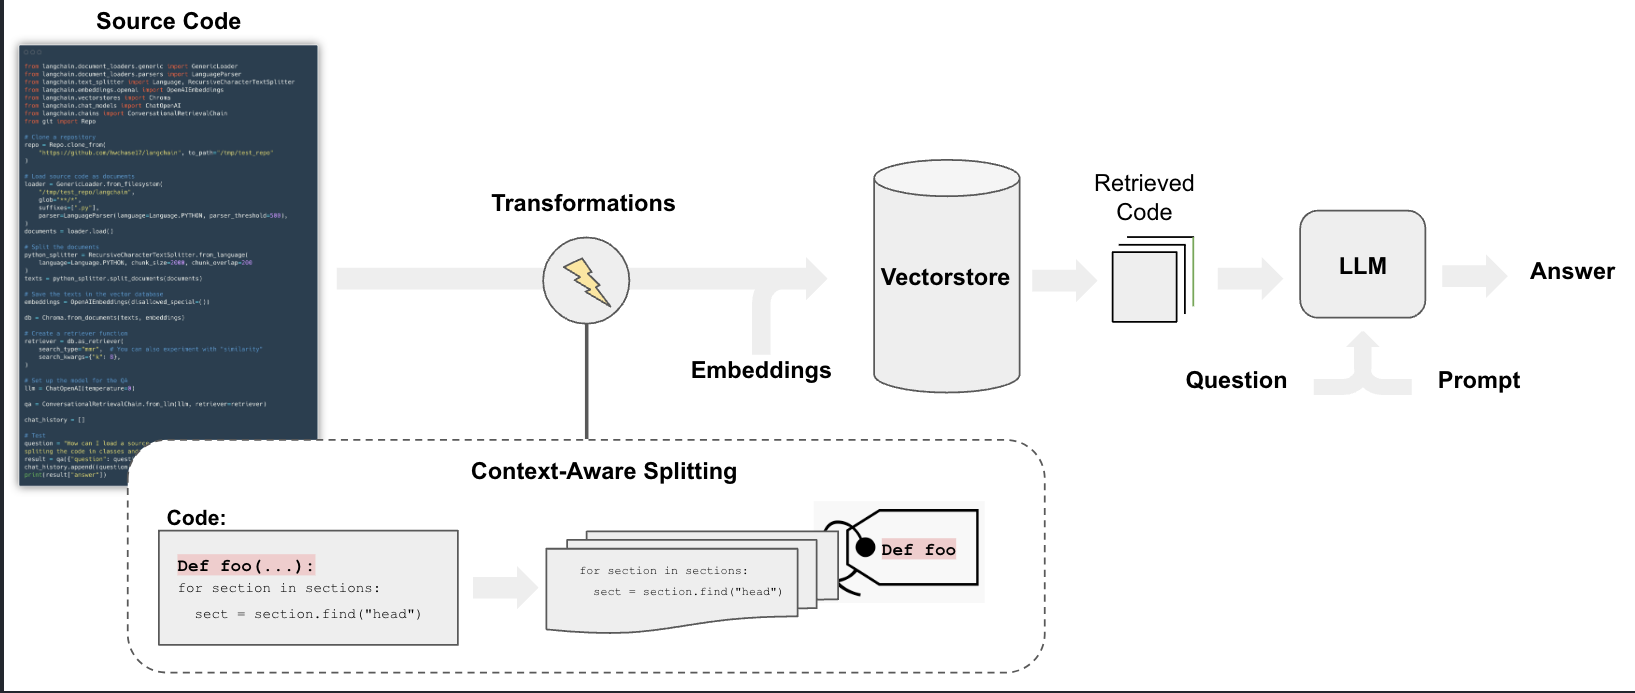

In [ ]:
img = display('/home/fahad/Pictures/Screenshots/Screenshot from 2024-10-19 09-54-46.png')
img

In [1]:
from git import Repo
from langchain.text_splitter import Language
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import LanguageParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationSummaryMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.document_loaders import TextLoader


In [ ]:
%pwd

In [ ]:
!mkdir test_repo

In [3]:
repo_path = "test_repo/"
# repo = Repo.clone_from("https://github.com/entbappy/End-to-end-Medical-Chatbot-Generative-AI", to_path=repo_path)

In [ ]:
%ls 'test_repo/'

In [ ]:
docs = []
for dirpath, dirnames, filenames in os.walk(repo_path):
    for file in filenames:
        ext = file.split('.')[-1]
        try:
            if ext == 'py':
                print("FILE: ", file)
                loader = TextLoader(os.path.join(dirpath, file), encoding='utf-8')
                docs.extend(loader.load_and_split())
        except Exception as e:
            pass

In [21]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


TEXT_SPLITTER_CHUNK_PARAMS = {
    "chunk_size": 500,
    "chunk_overlap": 20,
    "length_function": len,
}

text_splitter = RecursiveCharacterTextSplitter(**TEXT_SPLITTER_CHUNK_PARAMS)
texts = text_splitter.split_documents(docs)

In [22]:
from dotenv import load_dotenv
load_dotenv() 

# Embedding models: https://python.langchain.com/v0.1/docs/integrations/text_embedding/
GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.vectorstores import Chroma


embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=GOOGLE_API_KEY)

text_vdb = Chroma.from_documents(texts, embeddings, persist_directory='./db')

In [17]:
os.environ["GEMINI_API_KEY"] = GOOGLE_API_KEY

In [35]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# embeddings=OpenAIEmbeddings(disallowed_special=())
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=GOOGLE_API_KEY)

In [ ]:
from langchain_chroma import Chroma

vectordb = Chroma.from_documents(texts, embedding=embeddings, persist_directory='./db')

In [20]:
# vectordb.persist()

In [20]:
from langchain_google_genai import ChatGoogleGenerativeAI

# llm = ChatOpenAI(model_name="gpt-4")
# llm = ChatOpenAI()
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",temperature=0.5, max_tokens=1048, google_api_key=GOOGLE_API_KEY)

In [31]:
memory = ConversationSummaryMemory(llm=llm, memory_key = "chat_history", return_messages=True)

In [32]:
qa = ConversationalRetrievalChain.from_llm(llm, retriever=vectordb.as_retriever(search_type="mmr", search_kwargs={"k":8}), memory=memory)

In [33]:
question = "which method should be type annotated of this project. Give one line of reasoning for which you think type annotation is important"

In [ ]:
result = qa(question)
print(result['answer'])

In [ ]:
question = "add proper type annotation with small reasoning description about why and which type hints is added"
result = qa(question)
print(result['answer'])